In [1]:
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
import copy
import numpy as np
from timeit import default_timer
import torch.nn.functional as F
import torch.nn as nn
from utils.losses import EnergyScore, KernelScore, VariogramScore
from models.fno import FNO2d
from models.pfno import PFNO_Wrapper
from models.laplace import LA_Wrapper
from models.mcdropout import generate_mcd_samples
from data.datasets import DarcyFlowDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataloaders

In [2]:
batch_size = 32
n_samples = 100 # Samples to create from predictive distributions

In [3]:
data_dir = "../data/DarcyFlow/processed/"
train_data = DarcyFlowDataset(data_dir, test = False, downscaling_factor=2)
test_data = DarcyFlowDataset(data_dir, test = True)

# Get domain and range
x,y = train_data.get_coordinates()
L = train_data.get_domain_range()

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

n_train = train_data.__len__()
n_test = test_data.__len__()

## Visualize samples

Text(0, 0.5, 'Darcy flow solution')

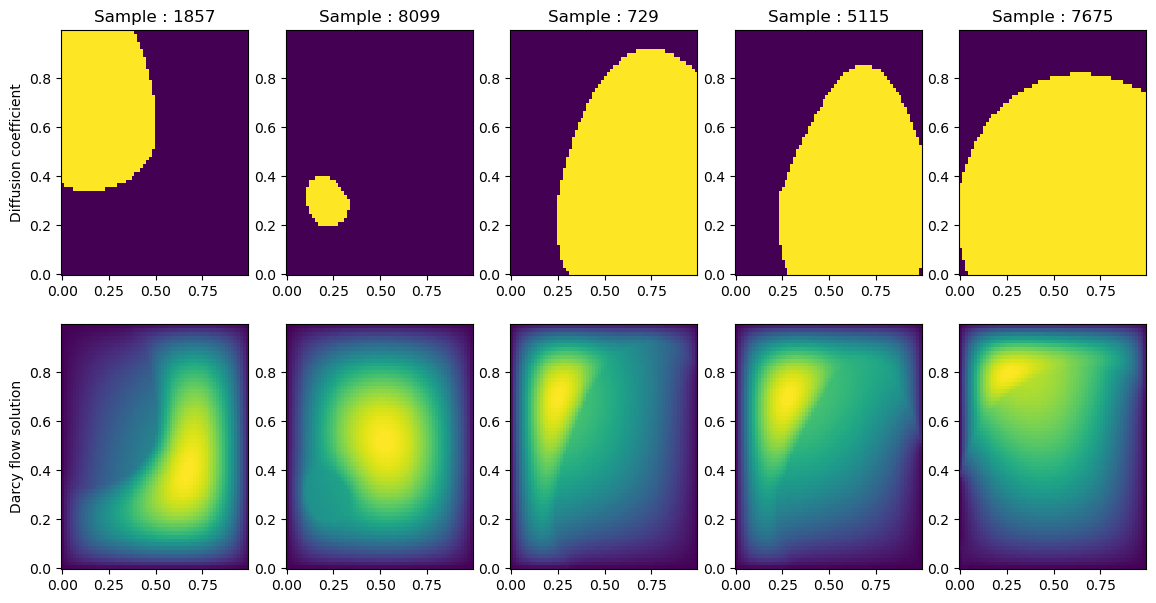

In [4]:
samples = np.random.randint(0, train_data.__len__(),5)

fig, axs = plt.subplots(2, 5, figsize=(14, 7))
for s, sample in enumerate(samples):
    a,u = train_data.__getitem__(sample)
    axs[0,s].pcolormesh(x, y, a[0], shading = "nearest")
    axs[1,s].pcolormesh(x, y, u[0], shading = "nearest")
    axs[0,s].set_title(f"Sample : {sample}")
axs[0, 0].set_ylabel(f"Diffusion coefficient")
axs[1, 0].set_ylabel(f"Darcy flow solution")

# Losses and parameters

In [5]:
# Losses and parameters
l2loss = LpLoss(d=2, p=2, L = L)
energy_score = EnergyScore(d = 2, p = 2, type = "lp", L = L)

# Training parameters
epochs = 10
learning_rate = 0.005
dropout_rate = 0.1
weight_decay = 10e-4

# Train base model

In [6]:
dropout_model = FNO2d(n_modes=(16,16), hidden_channels=32, in_channels = 3,
                        dropout_rate=dropout_rate, lifting_channels = 64,
                        projection_channels = 64)
dropout_model = dropout_model.to(device)

n_params = count_model_params(dropout_model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()



Our model has 1188513 parameters.


In [7]:
optimizer = torch.optim.Adam(dropout_model.parameters(),lr=learning_rate, weight_decay=weight_decay)

In [8]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    dropout_model.train()
    t1 = default_timer()
    train_l2 = 0
    for sample in train_loader:
        a, u = sample
        a = a.to(device)
        u = u.to(device)

        optimizer.zero_grad()
        out = dropout_model(a)
        
        l2 = l2loss(out.view(batch_size, -1), u.view(batch_size, -1))
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()

    dropout_model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            a, u = sample
            a = a.to(device)
            u = u.to(device)

            out = dropout_model(a)
            test_l2 += l2loss(out.view(batch_size, -1), u.view(batch_size, -1)).item()

    train_l2 /= n_train
    test_l2 /= n_test
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_l2, test_l2))

Epoch-0, Time-61.4089, Train-L2-0.0085, Test-L2-0.0055
Epoch-1, Time-58.2345, Train-L2-0.0059, Test-L2-0.0053
Epoch-2, Time-58.1371, Train-L2-0.0054, Test-L2-0.0047
Epoch-3, Time-58.2791, Train-L2-0.0052, Test-L2-0.0059
Epoch-4, Time-58.2268, Train-L2-0.0048, Test-L2-0.0046
Epoch-5, Time-58.1435, Train-L2-0.0048, Test-L2-0.0043
Epoch-6, Time-58.1946, Train-L2-0.0047, Test-L2-0.0042
Epoch-7, Time-58.2870, Train-L2-0.0046, Test-L2-0.0045
Epoch-8, Time-58.2331, Train-L2-0.0046, Test-L2-0.0039
Epoch-9, Time-58.2475, Train-L2-0.0046, Test-L2-0.0056


# MC Dropout

In [9]:
dropout_model.train()
""" Prediction """
mse_dropout = 0
es_dropout = 0
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        a, u = sample
        a = a.to(device)
        u = u.to(device)
        out = generate_mcd_samples(dropout_model, a, u.shape, n_samples=n_samples)
        mse_dropout += l2loss(out.mean(axis = -1).view(batch_size, -1), u.view(batch_size, -1)).item() / n_test
        es_dropout += energy_score(out, u).item() / n_test


print('MSE:', mse_dropout)
print('ES:', es_dropout)

MSE: 0.005428446859121322
ES: 0.000785327136516571


# Laplace approximation

In [10]:
la_pfno = LA_Wrapper(dropout_model, n_samples=n_samples, method = "last_layer", hessian_structure = "full")
la_pfno.fit(train_loader)

In [11]:
""" Prediction """
mse_la = 0
es_la = 0
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        a, u = sample
        a = a.to(device)
        u = u.to(device)
        out = la_pfno.predictive_samples(a)
        mse_la += l2loss(out.mean(axis = -1).view(batch_size, -1), u.view(batch_size, -1)).item() / n_test
        es_la += energy_score(out, u).item() / n_test


print('MSE:', mse_la)
print('ES:', es_la)

MSE: 0.00771017374098301
ES: 0.002362343188375235


# PFNO

In [12]:
hidden_model = FNO2d(n_modes=(16,16), hidden_channels=32, in_channels = 3, dropout_rate=dropout_rate, lifting_channels = 64, projection_channels = 64)
pfno_model = PFNO_Wrapper(hidden_model, n_samples = 3)

#pfno_model = PFNO_Wrapper(copy.deepcopy(dropout_model), n_samples = 3)
pfno_model.to(device)
# Model and optimizer
optimizer = torch.optim.Adam(pfno_model.parameters(), lr = learning_rate, weight_decay = weight_decay)

In [13]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    pfno_model.train()
    t1 = default_timer()
    train_l2 = 0
    for sample in train_loader:
        a, u = sample
        a = a.to(device)
        u = u.to(device)

        optimizer.zero_grad()
        out = pfno_model(a)
        
        l2 = energy_score(out,u)
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()

    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            a, u = sample
            a = a.to(device)
            u = u.to(device)

            out = pfno_model(a)
            test_l2 += energy_score(out,u)

    train_l2 /= n_train
    test_l2 /= n_test
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_l2, test_l2))

Epoch-0, Time-67.0983, Train-L2-0.0014, Test-L2-0.0011
Epoch-1, Time-66.7076, Train-L2-0.0010, Test-L2-0.0010
Epoch-2, Time-67.2100, Train-L2-0.0010, Test-L2-0.0009
Epoch-3, Time-67.1636, Train-L2-0.0010, Test-L2-0.0012
Epoch-4, Time-67.4447, Train-L2-0.0009, Test-L2-0.0009
Epoch-5, Time-67.0807, Train-L2-0.0009, Test-L2-0.0009
Epoch-6, Time-66.8877, Train-L2-0.0009, Test-L2-0.0009
Epoch-7, Time-67.1328, Train-L2-0.0008, Test-L2-0.0008
Epoch-8, Time-67.1442, Train-L2-0.0008, Test-L2-0.0008
Epoch-9, Time-67.3816, Train-L2-0.0008, Test-L2-0.0008


In [14]:
pfno_model.train()
""" Prediction """
mse_pfno = 0
es_pfno = 0
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        a, u = sample
        a = a.to(device)
        u = u.to(device)
        out = pfno_model(a, n_samples = n_samples)
        mse_pfno += l2loss(out.mean(axis = -1).view(batch_size, -1), u.view(batch_size, -1)).item() / n_test
        es_pfno += energy_score(out, u).item() / n_test


print('MSE:', mse_pfno)
print('ES:', es_pfno)

MSE: 0.006559212401509286
ES: 0.0008151449467986823


# Metric comparison

In [15]:
print(f"Dropout \nMSE: {mse_dropout} \t ES: {es_dropout}")
print(f"LA \nMSE: {mse_la} \t ES: {es_la}")
print(f"PFNO \nMSE: {mse_pfno} \t ES: {es_pfno}")

Dropout 
MSE: 0.005428446859121322 	 ES: 0.000785327136516571
LA 
MSE: 0.00771017374098301 	 ES: 0.002362343188375235
PFNO 
MSE: 0.006559212401509286 	 ES: 0.0008151449467986823


# Visualizations

In [16]:
samples = np.random.randint(0,n_test,5)

pfno_model.train()
dropout_model.train()
""" Prediction """
pred_pfno = []
pred_dropout = []
pred_la = []

with torch.no_grad():    
    index = 0
    for sample in samples:
        a,u = test_data.__getitem__(sample)
        a = a.to(device).unsqueeze(0)
        u = u.to(device).unsqueeze(0)
        dropout_pred = generate_mcd_samples(dropout_model, a, u.shape, n_samples=n_samples)
        pfno_pred = pfno_model(a, n_samples = n_samples)
        la_pred = la_pfno.predictive_samples(a)

        pred_dropout.append( dropout_pred )
        pred_pfno.append( pfno_pred )
        pred_la.append( la_pred )


pred_pfno = torch.cat(pred_pfno, dim = 0).cpu().numpy()
pred_dropout = torch.cat(pred_dropout, dim = 0).cpu().numpy()
pred_la = torch.cat(pred_la, dim = 0).cpu().numpy()

In [17]:
# Parameters
alpha = 0.05

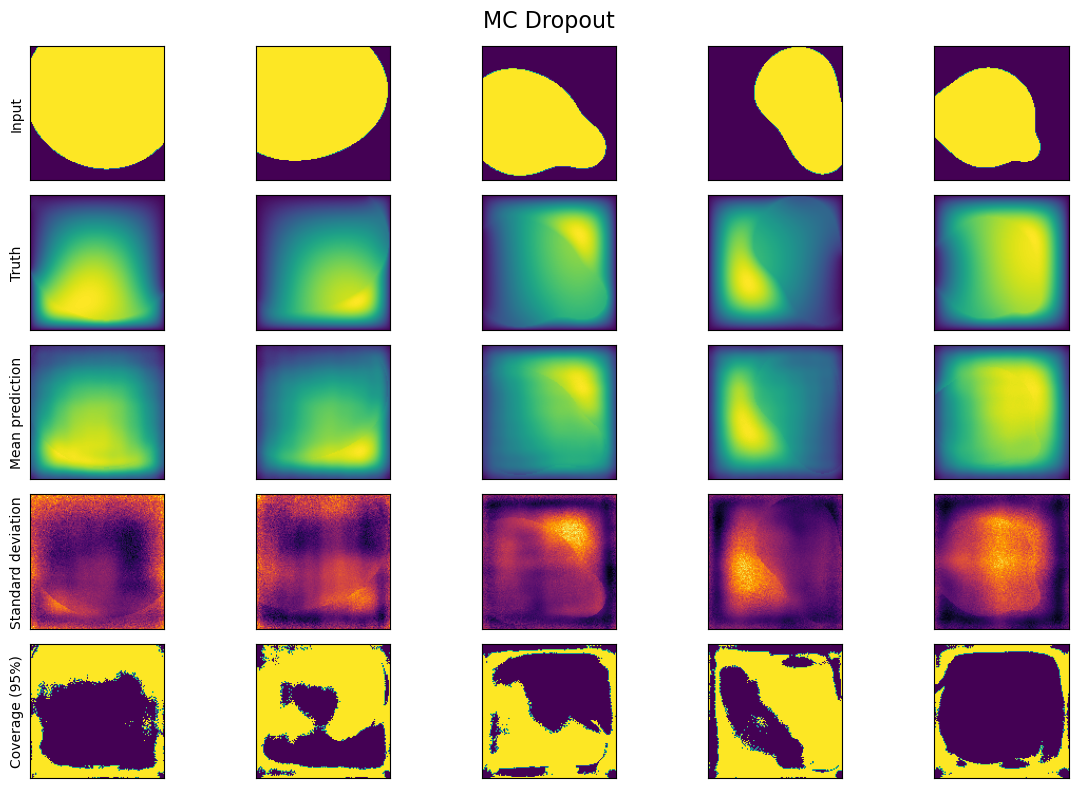

In [18]:
""" Plotting """ 
fig, axs = plt.subplots(5, 5, figsize = (12, 8))
index = 0
for i, sample in enumerate(samples):
        a,u = test_data.__getitem__(sample)
        a = a.cpu().numpy()
        u = u.cpu().numpy()
        # Calculate coverage
        q_lower = np.quantile(pred_dropout[i,0],alpha/2, axis = -1)
        q_upper = np.quantile(pred_dropout[i,0],1-alpha/2, axis = -1)
        coverage = (u>q_lower) & (u<q_upper)

        axs[0,i].imshow(a[0])
        axs[1,i].imshow(u[0])
        axs[2,i].imshow(pred_dropout[i,0].mean(axis = -1))
        axs[3,i].imshow(pred_dropout[i,0].std(axis = -1), cmap = "inferno")
        axs[4,i].imshow(coverage[0])

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.margins(0)

axs[0,0].set_ylabel('Input')
axs[1,0].set_ylabel('Truth')
axs[2,0].set_ylabel('Mean prediction')
axs[3,0].set_ylabel('Standard deviation')
axs[4,0].set_ylabel('Coverage (95%)')
fig.suptitle('MC Dropout', fontsize=16)

fig.tight_layout()

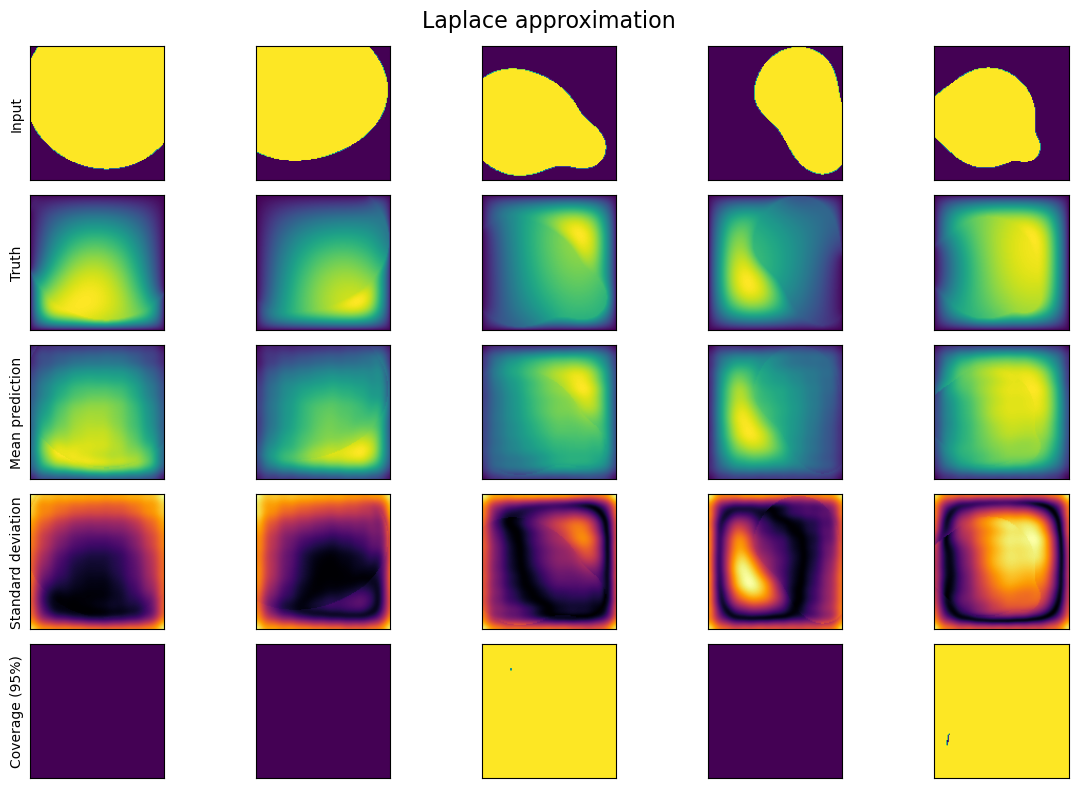

In [19]:
""" Plotting """ 
fig, axs = plt.subplots(5, 5, figsize = (12, 8))
index = 0
for i, sample in enumerate(samples):
        a,u = test_data.__getitem__(sample)
        a = a.cpu().numpy()
        u = u.cpu().numpy()
        # Calculate coverage
        q_lower = np.quantile(pred_la[i,0],alpha/2, axis = -1)
        q_upper = np.quantile(pred_la[i,0],1-alpha/2, axis = -1)
        coverage = (u>q_lower) & (u<q_upper)
        axs[0,i].imshow(a[0])
        axs[1,i].imshow(u[0])
        axs[2,i].imshow(pred_la[i,0].mean(axis = -1))
        axs[3,i].imshow(pred_la[i,0].std(axis = -1), cmap = "inferno")
        axs[4,i].imshow(coverage[0])


for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.margins(0)

axs[0,0].set_ylabel('Input')
axs[1,0].set_ylabel('Truth')
axs[2,0].set_ylabel('Mean prediction')
axs[3,0].set_ylabel('Standard deviation')
axs[4,0].set_ylabel('Coverage (95%)')
fig.suptitle('Laplace approximation', fontsize=16)

fig.tight_layout()

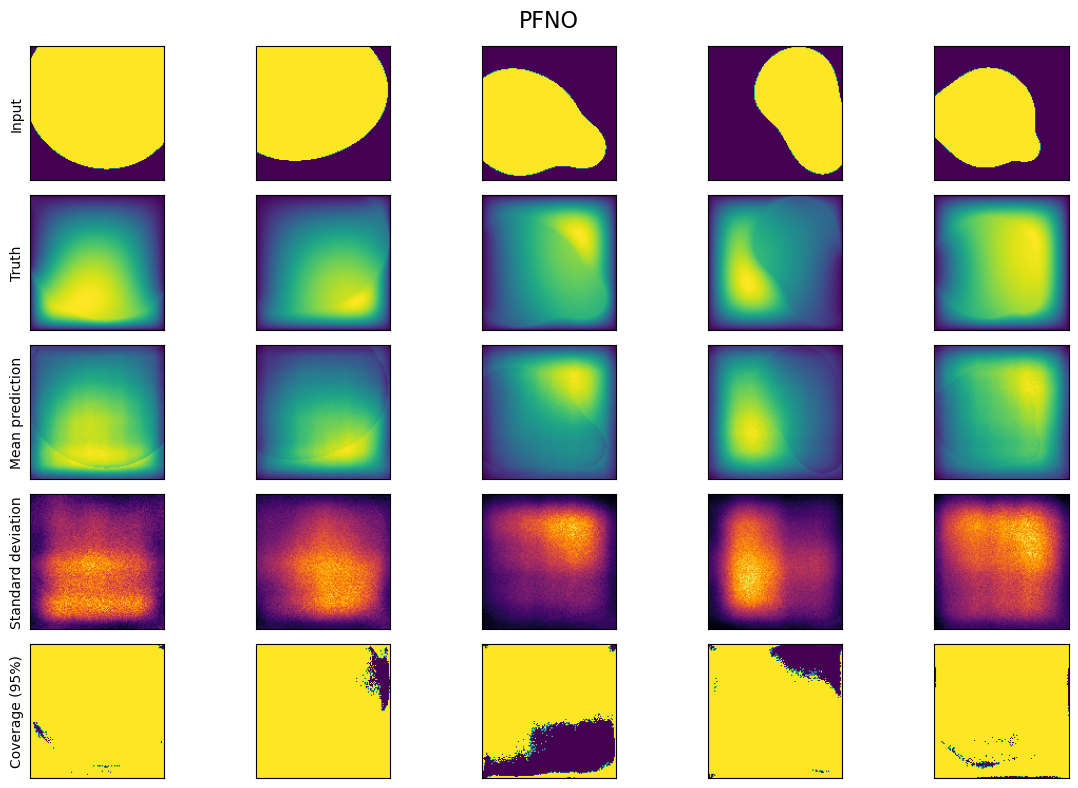

In [20]:
""" Plotting """ 
fig, axs = plt.subplots(5, 5, figsize = (12, 8))
index = 0
for i, sample in enumerate(samples):
        a,u = test_data.__getitem__(sample)
        a = a.cpu().numpy()
        u = u.cpu().numpy()
        # Calculate coverage
        q_lower = np.quantile(pred_pfno[i,0],alpha/2, axis = -1)
        q_upper = np.quantile(pred_pfno[i,0],1-alpha/2, axis = -1)
        coverage = (u>q_lower) & (u<q_upper)
        axs[0,i].imshow(a[0])
        axs[1,i].imshow(u[0])
        axs[2,i].imshow(pred_pfno[i,0].mean(axis = -1))
        axs[3,i].imshow(pred_pfno[i,0].std(axis = -1), cmap = "inferno")
        axs[4,i].imshow(coverage[0])


for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.margins(0)

axs[0,0].set_ylabel('Input')
axs[1,0].set_ylabel('Truth')
axs[2,0].set_ylabel('Mean prediction')
axs[3,0].set_ylabel('Standard deviation')
axs[4,0].set_ylabel('Coverage (95%)')
fig.suptitle('PFNO', fontsize=16)

fig.tight_layout()